<a href="https://colab.research.google.com/github/TheS1n233/Distributed-Learning-Project5/blob/experiments/other_optimezers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [88]:
!pip install --upgrade torch


## Imports

In [89]:
import torch
import argparse
from torch.optim.optimizer import Optimizer, required
import torch
import torchvision
import torchvision.transforms as transforms
import random
import numpy as np
import json
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, SequentialLR, LinearLR
import matplotlib.pyplot as plt
import copy
import time
from torch.amp import GradScaler, autocast
import os
from google.colab import drive
from torch.utils.data import DataLoader, random_split
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.optim.lr_scheduler")
drive.mount('/content/drive')
if not os.path.exists('/content/drive/MyDrive'):
    raise RuntimeError("Google Drive not mounted correctly!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [90]:
NUM_EPOCHS = 2
BATCH_SIZE = 64
NUM_WORKER_LIST = [2, 4, 8]
LOCAL_STEPS = [4, 8, 16, 32, 64]
LR = 0.01
WD = 0.001
MOMENTUM = 0.9
ALPHA = 1.0
BETA = 0.4
SAVE_PATH="/content/drive/My Drive/Colab Notebooks/Traning_summary/"
CHECKPOINT_NAME = "checkpoint_slowmo_last.pth"

## Model

In [91]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=5)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=5)

        self.fc1 = nn.Linear(64 * 5 * 5, 384)
        self.fc2 = nn.Linear(384, 192)
        self.fc3 = nn.Linear(192, 100)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)

        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)

        return x

In [92]:
# Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=10, delta=0, path='/content/drive/MyDrive/Early2checkpoint.pt', verbose=False):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta
        self.path = path
        self.verbose = verbose

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, optimizer=None):
        if self.verbose:
            print(f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...")
        checkpoint = {
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict() if optimizer else None,
            'val_loss_min': val_loss
        }
        torch.save(checkpoint, self.path)
        self.val_loss_min = val_loss



## Function to get train, test and val dataset

In [93]:
def calulcate_mean_std(batch_size=100, verbose=True):
    # Transform only for caluclate meaning of the dataset
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    # Load the CIFAR-100 training dataset
    train_dataset = torchvision.datasets.CIFAR100(
        root='./data',
        train=True,
        download=True,
        transform=transform
    )


    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=False, num_workers=0)

    # Initialize sums for calculating mean and std
    mean = torch.zeros(3)
    std = torch.zeros(3)

    for images, _ in train_loader:
        # Compute mean and std for each channel
        mean += images.mean(dim=[0, 2, 3])
        std += images.std(dim=[0, 2, 3])

    mean /= len(train_loader)
    std /= len(train_loader)

    if verbose:
      print("Mean: ", mean)
      print("Std: ", std)

    return mean, std

In [94]:
def get_dataset(batch_size, verbose=True):

    print("Start loading data with batch_size", batch_size)

    mean, std = calulcate_mean_std()

    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[mean[0].item(), mean[1].item(), mean[2].item()],
                            std=[std[0].item(), std[1].item(), std[2].item()])
    ])

    transform_test = transforms.Compose([
        transforms.CenterCrop(32),
        transforms.ToTensor(),
        transforms.Normalize(mean=[mean[0].item(), mean[1].item(), mean[2].item()],
                            std=[std[0].item(), std[1].item(), std[2].item()])
    ])

    # Load CIFAR-100 dataset
    start_time = time.time()
    train_dataset = torchvision.datasets.CIFAR100(
        root='./data',
        train=True,
        download=True,
        transform=transform_train
    )
    test_dataset = torchvision.datasets.CIFAR100(
        root='./data',
        train=False,
        download=True,
        transform=transform_test
    )

    if verbose:
      print(f"Dataset loading time: {time.time() - start_time:.2f} seconds")

    # Split training and validation sets
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

    # Data loaders
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        pin_memory=True
    )

    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )

    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )

    if verbose:
      for i, (inputs, labels) in enumerate(train_loader):
          print(f"Batch {i}: inputs shape: {inputs.shape}, labels shape: {labels.shape}")
          if i == 10:
              break
      print(f"Data loading for 10 batches completed.")
      print(f"Training dataset size: {len(train_dataset)}")
      print(f"Validation dataset size: {len(val_dataset)}")
      print(f"Test dataset size: {len(test_dataset)}")


    print("Data load correctly...")

    return train_loader, val_loader, test_loader

In [98]:
class CheckpointSaver:

  def __init__(self, k, j, hyperparams, epochs, path=SAVE_PATH, checkpoint_name=CHECKPOINT_NAME):
    self.checkpoint_name = checkpoint_name
    self.timestamp = time.strftime("%Y%m%d-%H%M%S")
    self.path = path
    self.k = k
    self.j = j
    self.hyperparams = hyperparams
    self.epochs = epochs
    self.create_files()

  def create_files(self):
    os.makedirs(self.path, exist_ok=True)

    self.metrics_files = {
        'global_train_acc': os.path.join(self.path, f'slowmo_train_accuracy_{self.timestamp}_K={str(self.k)}_J={ str(self.j)}.txt'),
        'val_acc': os.path.join(self.path, f'slowmo_val_accuracy_{self.timestamp}_K={str(self.k)}_J={ str(self.j)}.txt'),
        'global_train_loss': os.path.join(self.path, f'slowmo_train_loss_{self.timestamp}_K={str(self.k)}_J={ str(self.j)}.txt'),
        'val_loss': os.path.join(self.path, f'slowmo_val_loss_{self.timestamp}_K={str(self.k)}_J={ str(self.j)}.txt'),
        'summary': os.path.join(self.path, f'slowmo_summary_{self.timestamp}_K={str(self.k)}_J={ str(self.j)}.txt'),
    }

    with open(os.path.join(self.path, f'slowmo_experiment_config_{self.timestamp}_K={str(self.k)}_J={ str(self.j)}.txt'), 'w') as f:
        f.write(f"Experiment Configuration:\n")
        f.write(f"Optimizer: slowmo\n")
        f.write(f"K = {self.k}; J = {self.j}\n")
        f.write(f"Hyperparameters: {str(self.hyperparams)}\n")
        f.write(f"Number of epochs: {self.epochs}\n")
        f.write(f"Timestamp: {self.timestamp}\n")

  def save_sumamry(self, stats, epoch, global_train_accuracy, val_acc, global_train_loss, val_loss):
      try:
          with open(self.metrics_files['summary'], 'a') as f:
            f.write(f"Epoch {epoch}\n")
            f.write(f"Train Loss: {global_train_loss:.4f}, Train Acc: {global_train_accuracy * 100:.2f}%\n")
            f.write(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc * 100:.2f}%\n")
            f.write(f"Avg computation time: {stats['avg_computation_time']:.4f}s\n")
            f.write(f"Avg communication time: {stats['avg_communication_time']:.4f}s\n")
            f.write(f"Computation/Communication ratio: {stats['computation_to_communication_ratio']:.2f}\n")
            f.write("\n\n")

      except Exception as e:
          print(f"Error saving metrics: {e}")

  def save_checkpoint(self, epoch, global_train_accuracy, val_acc, global_train_loss, val_loss):
      try:
          with open(self.metrics_files['global_train_acc'], 'a') as f:
              f.write(f"{epoch},{global_train_accuracy * 100:.2f}%\n")
          with open(self.metrics_files['val_acc'], 'a') as f:
              f.write(f"{epoch},{val_acc * 100:.2f}%\n")
          with open(self.metrics_files['global_train_loss'], 'a') as f:
              f.write(f"{epoch},{global_train_loss:.4f}\n")
          with open(self.metrics_files['val_loss'], 'a') as f:
              f.write(f"{epoch},{val_loss:.4f}\n")
      except Exception as e:
          print(f"Error saving metrics: {e}")

  def end_sumamry(self, test_acc):
      try:
          with open(self.metrics_files['summary'], 'a') as f:
            f.write(f"test_acc {test_acc}\n")
            f.write("\n\n")

      except Exception as e:
          print(f"Error saving metrics: {e}")

  def save_model_checkpoint(self, model, optimizer, epoch):
      checkpoint_path = os.path.join(self.path + self.checkpoint_name)
      try:
          torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
          }, checkpoint_path)
          print("Checkpoint saved correctly")
      except Exception as e:
          print(f"Error saving model checkpoint: {e}")

  def load_model_checkpoint(self):
      try:
          checkpoint = torch.load(self.path + self.checkpoint_name)
          start_epoch = checkpoint['epoch'] + 1
          print(f"Checkpoint loaded successfully. Resuming from epoch {start_epoch}")
          return checkpoint['model_state_dict'], checkpoint['optimizer_state_dict'], start_epoch
      except Exception as e:
          print(f"Error loading model checkpoint: {e}")
          return 0

  def delete_checkpoint(self):
      final_path = self.path
      if os.path.exists(final_path):
            for file_name in os.listdir(final_path):
                file_path = os.path.join(final_path, file_name)
                if os.path.isfile(file_path):
                    os.remove(file_path)
            print(f"All existing checkpoints in {final_path} have been deleted.")
      else:
            print(f"No checkpoint folder found at {final_path}.")

In [99]:
class TimeTracker:
    def __init__(self):
        self.computation_times = []
        self.communication_times = []
        self.total_computation = 0.0
        self.total_communication = 0.0
        self.epoch_comp_times = []
        self.epoch_comm_times = []

    def start_computation(self):
        self.comp_start = time.time()

    def end_computation(self):
        comp_time = time.time() - self.comp_start
        self.total_computation += comp_time
        self.computation_times.append(comp_time)
        return comp_time

    def start_communication(self):
        self.comm_start = time.time()

    def end_communication(self):
        comm_time = time.time() - self.comm_start
        self.total_communication += comm_time
        self.communication_times.append(comm_time)
        return comm_time

    def record_epoch(self):
        """Record times for the current epoch"""
        self.epoch_comp_times.append(self.total_computation)
        self.epoch_comm_times.append(self.total_communication)

    def get_statistics(self):
        """Return summary statistics"""
        stats = {
            'avg_computation_time': np.mean(self.computation_times),
            'avg_communication_time': np.mean(self.communication_times),
            'total_computation_time': self.total_computation,
            'total_communication_time': self.total_communication,
            'computation_to_communication_ratio': self.total_computation / (self.total_communication + 1e-10)
        }
        return stats

# SlowMo Framework

Start loading data with batch_size 64
Files already downloaded and verified
Mean:  tensor([0.5071, 0.4865, 0.4409])
Std:  tensor([0.2667, 0.2558, 0.2754])
Files already downloaded and verified
Files already downloaded and verified
Dataset loading time: 2.17 seconds
Batch 0: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 1: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 2: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 3: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 4: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 5: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 6: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 7: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 8: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torc

<ipython-input-98-25180ded9eee>:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(self.path + self.checkpoint_name)


Checkpoint saved correctly
Epoch 1/2
Train Loss: 3.6844, Train Acc: 14.26%
Val Loss: 3.6543, Val Acc: 13.66%
Avg computation time: 0.2421s
Avg communication time: 0.0007s
Computation/Communication ratio: 345.41
Checkpoint saved correctly
Epoch 2/2
Train Loss: 3.3868, Train Acc: 18.16%
Val Loss: 3.4637, Val Acc: 16.52%
Avg computation time: 0.2473s
Avg communication time: 0.0007s
Computation/Communication ratio: 338.85
Test Accuracy: 17.43

Final Time Statistics:
Total computation time: 38.58s
Total communication time: 0.11s
Overall computation/communication ratio: 338.85
All existing checkpoints in /content/drive/My Drive/Colab Notebooks/Traning_summary/ have been deleted.


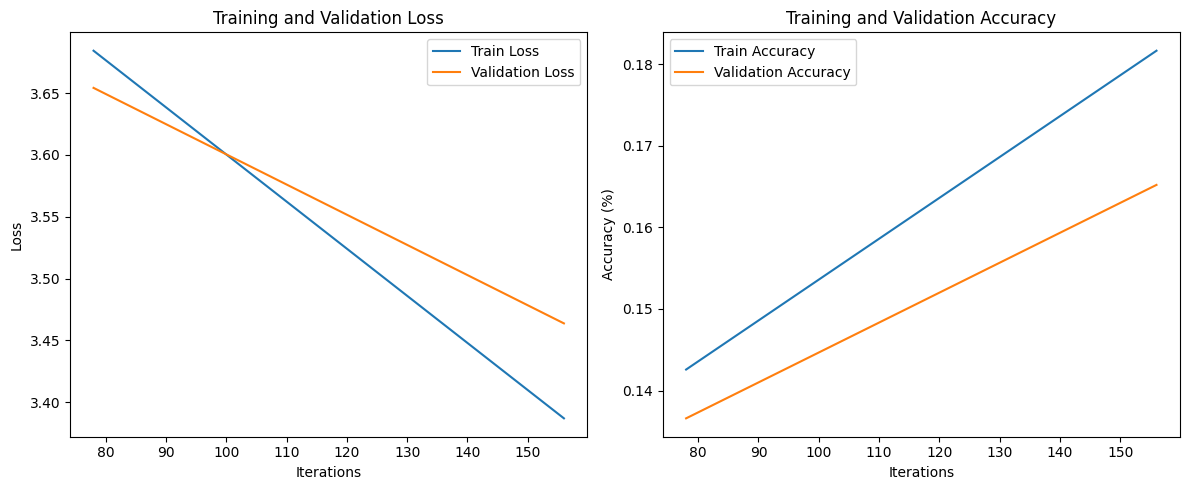

Running SlowMo with 2 workers and 8 local steps
Starting training from scratch


KeyboardInterrupt: 

In [101]:
def split_cifar100(dataset, num_workers):
    indices = np.random.permutation(len(dataset))
    splits = np.array_split(indices, num_workers)
    return [torch.utils.data.Subset(dataset, split) for split in splits]

def slowmo_alg(train_loader, val_loader, test_loader, device, num_workers, local_steps, num_epochs, batch_size, hyperparams, slowmo_params, verbose=True):
    dataset_size = len(train_loader.dataset)
    datasets = split_cifar100(train_loader.dataset, num_workers)
    workers = [
        DataLoader(datasets[i], batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
        for i in range(num_workers)
    ]

    # Calculate number of iterations
    total_iterations = (num_epochs * (dataset_size // batch_size)) // (num_workers * local_steps)
    iterations_per_epoch = total_iterations // num_epochs

    cs = CheckpointSaver(
        j=local_steps,
        k=num_workers,
        hyperparams=hyperparams,
        epochs=num_epochs
    )


    global_model = LeNet5().to(device)
    # Check for existing checkpoint
    start_epoch = 0
    if os.path.exists(SAVE_PATH+CHECKPOINT_NAME):
        model_state_dict, optimizer_state_dict, start_epoch = cs.load_model_checkpoint()
        global_model.load_state_dict(model_state_dict)
        global_optimizer = optim.SGD(
            global_model.parameters(),
            lr=hyperparams['lr'],
            weight_decay=hyperparams['weight_decay'],
            momentum=hyperparams['momentum']
        )
        local_models = [copy.deepcopy(global_model).to(device) for _ in range(num_workers)]

        local_optimizers = [
            optim.SGD(
                model.parameters(),
                lr=hyperparams['lr'],
                weight_decay=hyperparams['weight_decay'],
                momentum=hyperparams['momentum'],
            ) for model in local_models
        ]
        # Load the state dicts into gloabl optimizer
        global_optimizer.load_state_dict(optimizer_state_dict)
        # Load the state dicts into each optimizer
        for op in local_optimizers:
            op.load_state_dict(optimizer_state_dict)

        print(f"Resumed training from iteration {start_epoch}")
    else:
        print("Starting training from scratch")

        global_optimizer = optim.SGD(
            global_model.parameters(),
            lr=hyperparams['lr'],
            weight_decay=hyperparams['weight_decay'],
            momentum=hyperparams['momentum']
        )

        local_models = [copy.deepcopy(global_model).to(device) for _ in range(num_workers)]
        local_optimizers = [
            optim.SGD(
                model.parameters(),
                lr=hyperparams['lr'],
                weight_decay=hyperparams['weight_decay'],
                momentum=hyperparams['momentum']
            ) for model in local_models
        ]

    with torch.no_grad():
        averaged_params = torch.nn.utils.parameters_to_vector(global_model.parameters()).clone()
        slow_momentum = torch.zeros_like(averaged_params, device=device)

    scheduler = CosineAnnealingLR(global_optimizer, T_max=num_epochs)
    schedulers = [CosineAnnealingLR(opt, T_max=num_epochs) for opt in local_optimizers]

    criterion = nn.CrossEntropyLoss()

    time_tracker = TimeTracker()

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []


    global_lr = global_optimizer.param_groups[0]['lr']
    for local_optimizer in local_optimizers:
        for param_group in local_optimizer.param_groups:
            param_group['lr'] = global_lr

    for iteration in range(1, total_iterations + 1):

        time_tracker.start_computation()

        with torch.no_grad():
            initial_params = torch.nn.utils.parameters_to_vector(global_model.parameters()).clone()

        worker_iters = [iter(workers[i]) for i in range(num_workers)]
        worker_train_losses = []
        worker_train_accuracies = []

        for worker_id in range(num_workers):
            # Reset/maintain optimizer buffers
            local_optimizers[worker_id].zero_grad()

            with torch.no_grad():
                torch.nn.utils.vector_to_parameters(
                    torch.nn.utils.parameters_to_vector(global_model.parameters()),
                    local_models[worker_id].parameters()
                )

            worker_loss, correct, total = 0.0, 0, 0
            for _ in range(local_steps):
                try:
                    inputs, labels = next(worker_iters[worker_id])
                except StopIteration:
                    worker_iters[worker_id] = iter(workers[worker_id])
                    inputs, labels = next(worker_iters[worker_id])

                inputs, labels = inputs.to(device), labels.to(device)
                local_optimizers[worker_id].zero_grad()
                outputs = local_models[worker_id](inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                local_optimizers[worker_id].step()

                worker_loss += loss.item()
                _, predicted = outputs.max(1)
                correct += predicted.eq(labels).sum().item()
                total += labels.size(0)

            worker_loss /= local_steps
            worker_accuracy = correct / total
            worker_train_losses.append(worker_loss)
            worker_train_accuracies.append(worker_accuracy)

        torch.cuda.empty_cache()

        time_tracker.end_computation()
        time_tracker.start_communication()

        # Average params for each local worker
        averaged_params = torch.zeros_like(averaged_params)
        for local_model in local_models:
            averaged_params += torch.nn.utils.parameters_to_vector(local_model.parameters()).to(device)
        averaged_params.div_(num_workers)
        averaged_params = averaged_params.to(device)

        gamma = global_optimizer.param_groups[0]['lr']

        if gamma == 0:
          print("Warning: Learning rate is 0. Skipping SlowMo update.")
          continue

        with torch.no_grad():
            slow_momentum = slow_momentum * slowmo_params['beta'] + (1 / gamma) * (initial_params - averaged_params)
            new_params = initial_params - slowmo_params['alpha'] * gamma * slow_momentum
            torch.nn.utils.vector_to_parameters(new_params, global_model.parameters())



        time_tracker.end_communication()
        torch.cuda.empty_cache()

        # Metrics for training
        global_train_loss = sum(worker_train_losses) / num_workers
        global_train_accuracy = sum(worker_train_accuracies) / num_workers

        # At each epoch
        if iteration % iterations_per_epoch == 0 or iteration == total_iterations:
            time_tracker.record_epoch()

            adjusted_epoch = iteration // iterations_per_epoch
            train_losses.append(global_train_loss)
            train_accuracies.append(global_train_accuracy)

            val_acc, val_loss = val_model(global_model, val_loader, criterion, device)

            val_losses.append(val_loss)
            val_accuracies.append(val_acc)

            torch.cuda.empty_cache()

            cs.save_checkpoint(adjusted_epoch, global_train_accuracy, val_acc, global_train_loss, val_loss)
            cs.save_model_checkpoint(global_model, local_optimizers[0], adjusted_epoch)

            if verbose:
                stats = time_tracker.get_statistics()
                print(f"Epoch {int(adjusted_epoch)}/{num_epochs}")
                print(f"Train Loss: {global_train_loss:.4f}, Train Acc: {global_train_accuracy * 100:.2f}%")
                print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc * 100:.2f}%")
                print(f"Avg computation time: {stats['avg_computation_time']:.4f}s")
                print(f"Avg communication time: {stats['avg_communication_time']:.4f}s")
                print(f"Computation/Communication ratio: {stats['computation_to_communication_ratio']:.2f}")

            scheduler.step()
            global_lr = global_optimizer.param_groups[0]['lr']
            for local_optimizer in local_optimizers:
                for param_group in local_optimizer.param_groups:
                    param_group['lr'] = global_lr

    test_acc = test_model(global_model, test_loader, device)

    if verbose:
      print("\nFinal Time Statistics:")
      final_stats = time_tracker.get_statistics()
      print(f"Total computation time: {final_stats['total_computation_time']:.2f}s")
      print(f"Total communication time: {final_stats['total_communication_time']:.2f}s")
      print(f"Overall computation/communication ratio: {final_stats['computation_to_communication_ratio']:.2f}")

    cs.end_sumamry(test_acc)
    cs.delete_checkpoint()

    return train_losses, val_losses, train_accuracies, val_accuracies, test_acc, iterations_per_epoch, total_iterations


def val_model(global_model, val_loader, criterion, device):
    global_model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = global_model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = correct / total
    return val_acc, val_loss

def test_model(global_model, test_loader, device):
    global_model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = global_model(inputs)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    test_acc = correct / total
    print(f"Test Accuracy: {test_acc * 100:.2f}")


# Visualization function
def plot_results(train_losses, val_losses, train_accuracies, val_accuracies, iterations_per_epoch, total_iterations):
    # Dynamic calculation record points
    recorded_iterations = len(train_losses)
    iterations = range(iterations_per_epoch, iterations_per_epoch * recorded_iterations + 1, iterations_per_epoch)

    # Ensure data length is consistent
    assert len(train_losses) == len(iterations), f"Train losses and iterations mismatch: {len(train_losses)} vs {len(iterations)}"
    assert len(val_losses) == len(iterations), f"Validation losses and iterations mismatch: {len(val_losses)} vs {len(iterations)}"

    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(iterations, train_losses, label="Train Loss")
    plt.plot(iterations, val_losses, label="Validation Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(iterations, train_accuracies, label="Train Accuracy")
    plt.plot(iterations, val_accuracies, label="Validation Accuracy")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy (%)")
    plt.title("Training and Validation Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    num_epochs = NUM_EPOCHS
    batch_size = BATCH_SIZE
    num_workers_list = NUM_WORKER_LIST
    local_steps_list = LOCAL_STEPS
    hyperparams = {
        'lr': LR,
        'weight_decay': WD,
        'momentum': MOMENTUM,
    }

    slowmo_params = {
        'alpha': ALPHA,
        'beta': BETA
    }

    train_loader, val_loader, test_loader = get_dataset(batch_size)

    for num_workers in num_workers_list:
        for local_steps in local_steps_list:
            print(f"Running SlowMo with {num_workers} workers and {local_steps} local steps")
            train_losses, val_losses, train_accuracies, val_accuracies, test_acc, iterations_per_epoch, total_iterations = slowmo_alg(
                train_loader=train_loader,
                val_loader=val_loader,
                test_loader=test_loader,
                device=device,
                num_workers=num_workers,
                local_steps=local_steps,
                num_epochs=num_epochs,
                batch_size=batch_size,
                hyperparams=hyperparams,
                slowmo_params=slowmo_params
            )

            plot_results(train_losses, val_losses, train_accuracies, val_accuracies, iterations_per_epoch, total_iterations)
